In [511]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from scipy.stats import mannwhitneyu
import scipy.stats as stats

#df=pd.read_excel("daten.xlsx")
df=pd.read_excel("DataFiles/UM_Career_Survey_March_24,_2023_14.51[1].xlsx")
if df.iloc[0,0]=='Start Date':
    QuestionDict=dict(zip(df.columns, df.iloc[0,:]))
    df=df.iloc[1:,:]


### generate List of Questions
QuestionList=[i for i in df.columns if i[0]=="Q"]

Questions=df.loc[:,df.columns.str.startswith('Q')]

### select Quanti Columns from df questionList


#not needed now
def normalize(df):
    return (df-df.min())/(df.max()-df.min())


print("Variable: QuestionDict --> Q.. in text.")
print("Variable: QuestionList --> all Qs")

for Q in QuestionList[1:7]:
    print(Q," --> ",QuestionDict[Q])



Variable: QuestionDict --> Q.. in text.
Variable: QuestionList --> all Qs
Q2  -->  Are you a UM student? - Selected Choice
Q2_3_TEXT  -->  Are you a UM student? - Other (please specify) - Text
Q3  -->  Which year of your studies are you in?
Q26  -->  What is you gender
Q24_1  -->  How old are you - -
Q4  -->  Which faculty are you in?


C:\Users\mr\miniconda3\envs\PyMax\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [512]:
## Likert Scale Corrections && check if Variables are detected

CleanDict={'no activities':'no',
           "I'd rather not say": np.nan,
        
          'rather prepared': 4,
           'neither prepared nor unprepared':3,
           'rather unprepared':2,
           'not at all prepared':1,
           'very prepared':5,
           
           'indifferent': 3,
           'quite important':4,
           'not very important':2,
           'very important':5,
           'not important at all':1,
           
           'somewhat disagree':2,
           'somewhat agree':4,
           'neither disagree nor agree':3,
           'fully agree':5,
           'fully disagree':1,
           
           "Definetely":5,
           "Might/ might not":3,
           "Likely":4,
           "Unlikely":2,
           "Definitely not":1
           
          }

    
#df[df.Q5,df.Q15_1]

Questions=Questions.replace(CleanDict)

for i in Questions.columns[8:]:
    print(Questions[i].unique())

['Yes' 'No' nan]
[nan 'No' 'no' 'No ' 'Yes' 'ECA' 'No.' 'EU Career, ECA' 'Not really '
 'Yes, I have checked them out' 'yes'
 'Yes, but not actively engaging with any.' 'linkdin, asa, eca'
 'EU career' '-' 'not at the moment ' 'Alumni LinkedIn group'
 'Not through UM' 'Not really' 'not really'
 'Not really. I have heard about it though' 'No not really ']
['ASA' 'LinkedIn' 'No' 'LinkedIn,ASA'
 'European Carreers Assocation (ECA),LinkedIn'
 'European Carreers Assocation (ECA)' 'Other (please specify)'
 'European Carreers Assocation (ECA),LinkedIn,ASA,Other (please specify)'
 'LinkedIn,ASA,Other (please specify)' 'No,LinkedIn'
 'European Carreers Assocation (ECA),LinkedIn,ASA' nan]
[nan 'UM Well-being Movement ' 'Eu Careers' 'Indeed, Facebook' 'Craiglist']
['UM Newsletter' 'Other (please specify)' 'Social media'
 'Friends/Peers/Students' 'Social media,Academic Staff,UM Newsletter'
 'Academic Staff' 'Friends/Peers/Students,UM Newsletter'
 'Social media,UM Newsletter'
 'Friends/Peers/Studen

# AutoSelect Columns

In [513]:
maxValue=5 ## maxLIkert Value
minStd=0.2

Numerical_Q=Questions[QuestionList].select_dtypes('number').dropna(axis=1, how='all') ## only numericals


Binary_Q=Numerical_Q.loc[:,[~(Numerical_Q[col]>1).any() for col in Numerical_Q.columns]].dropna(axis=1, how='all').fillna(0) # drop all with std lower 0.2 
nonBinary_Q=Numerical_Q.loc[:,[(Numerical_Q[col]>1).any() for col in Numerical_Q.columns]].dropna(axis=1, how='all') # drop all with std lower 0.2 


Likert_Q=Numerical_Q.loc[:,[~(Numerical_Q[col]>5).any() for col in Numerical_Q.columns]] # drop all with std lower 0.2 

Likert_Q=Likert_Q.loc[:,[(Likert_Q[col]>2).any() for col in Likert_Q.columns]] # drop all with std lower 0.2 

Likert_Q=Likert_Q.astype("float64")

non_Likert_Q=Questions[Questions.columns[~Questions.columns.isin(Likert_Q.columns)]]


TextQuestionsColumns=[i for i in list(non_Likert_Q.columns) if "TEXT" in i]
TextQuestions=non_Likert_Q[TextQuestionsColumns]
non_Likert_Q=non_Likert_Q.drop(TextQuestionsColumns,axis=1)


Age=Numerical_Q.loc[:,[(Numerical_Q[col]>20).any() for col in Numerical_Q.columns]]

Nominal_Q=Questions[QuestionList].select_dtypes(exclude='number') ## only non_numericals
#nonBinary_Q.describe()


# Nominal values

<AxesSubplot: ylabel='Q4'>

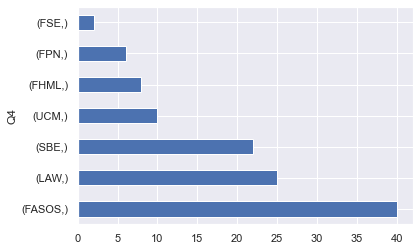

In [553]:
mostCommons=Nominal_Q.sample(n=1,axis=1).value_counts()[:8]
mostCommons.plot.barh()

# Correlations Analysis

In [436]:
### correlation filter

corrMap=nonBinary_Q.dropna(axis=1,how='all').corr().dropna(axis=1,how='all')
corrMap=corrMap[corrMap>0.4][corrMap<1].dropna(how='all').dropna(axis=1,how='all').fillna(0)
corrMap.style.background_gradient(axis=None).format(na_rep=' ', precision=2)  


,Q29_1,Q30_1,Q28_1,Q10_1,Q24_1.1,Q24_2,Q24_3,Q24_4,Q24_5,Q24_6
Q29_1,0.00,0.46,0.00,0.00,0.76,0.00,0.76,0.74,0.00,0.68
Q30_1,0.46,0.00,0.69,0.77,0.70,0.43,0.59,0.73,0.46,0.44
Q28_1,0.00,0.69,0.00,0.67,0.47,0.58,0.71,0.71,0.57,0.00
Q10_1,0.00,0.77,0.67,0.00,0.76,0.73,0.76,0.71,0.44,0.00
Q24_1.1,0.76,0.70,0.47,0.76,0.00,0.65,0.77,0.80,0.46,0.56
Q24_2,0.00,0.43,0.58,0.73,0.65,0.00,0.52,0.59,0.00,0.40
Q24_3,0.76,0.59,0.71,0.76,0.77,0.52,0.00,0.75,0.00,0.61
Q24_4,0.74,0.73,0.71,0.71,0.80,0.59,0.75,0.00,0.00,0.49
Q24_5,0.00,0.46,0.57,0.44,0.46,0.00,0.00,0.00,0.00,0.65
Q24_6,0.68,0.44,0.00,0.00,0.56,0.40,0.61,0.49,0.65,0.00


In [437]:
def spearmanCorr(df,pvalueLimit=0.05,CorrLimit=0.0):
    corrDict={}
    for x in range(len(df.columns)):
        for y in range(x+1,(len(df.columns))):
            a,b=df.columns[x],df.columns[y]

            try:
                corr,pvalue=stats.spearmanr(df[a], df[b],nan_policy='omit')
                if pvalue<pvalueLimit and abs(corr)>CorrLimit:
                    corrDict[(a,b)]=(corr,pvalue)
            except:
                #print(a,b)
                continue
    return corrDict


corrDict=spearmanCorr(nonBinary_Q, pvalueLimit=0.05, CorrLimit=0.4)

CorrDict=pd.DataFrame(corrDict)
CorrDict.index=["Spearman Corr","p-value"]
CorrDict.T.style.background_gradient(axis=None).format(na_rep=' ', precision=3)  

C:\Users\mr\miniconda3\envs\PyMax\lib\site-packages\seaborn\axisgrid.py:1826: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


          Q24_5     Q30_1
Q24_5  1.000000  0.373861
Q30_1  0.373861  1.000000


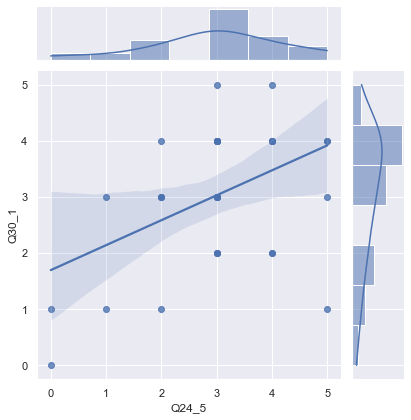

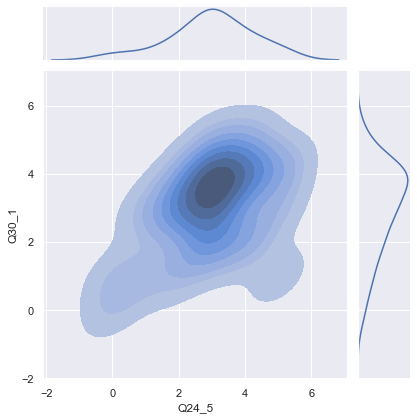

In [441]:
import random ### Select random Columns and show a jointplot
cols=nonBinary_Q.sample(n=2,axis='columns')


import seaborn as sns
import matplotlib.pyplot as plt


sns.set()


#f, axes = plt.subplots(1, 2)
sns.jointplot(x=cols.iloc[:,0],y=cols.iloc[:,1], kind="reg") #reg or kde
sns.jointplot(x=cols.iloc[:,0],y=cols.iloc[:,1], kind="kde", shade = True) #reg or kde


print(cols.corr(method='spearman'))

# Describe Likert Scales

In [442]:
QuestionDict["Q30_1"]

'How likely are you to recommend their offers to a friend? - -'

In [443]:
Likert_Q[Likert_Q.eq(0).any(1)]

,Q29_1,Q30_1,Q28_1,Q24_1.1,Q24_2,Q24_3,Q24_4,Q24_5,Q24_6
15,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
20,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
33,1.0,4.0,NaN,NaN,NaN,1.0,1.0,4.0,0.0
48,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
69,NaN,1.0,1.0,0.0,1.0,0.0,0.0,5.0,5.0
76,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [444]:
Likert_Q.min()

Q29_1      1.0
Q30_1      0.0
Q28_1      0.0
Q24_1.1    0.0
Q24_2      0.0
Q24_3      0.0
Q24_4      0.0
Q24_5      0.0
Q24_6      0.0
dtype: float64

In [445]:


#Section=Section.loc[:,[(Section[col]<=maxValue).any() for col in Section.columns]] # drop all with std lower 0.2 

#Likert_Q=Likert_Q.loc[:,[(Likert_Q[col]>2).any() for col in Likert_Q.columns]] ### check if it contains values greater 2


C:\Users\mr\miniconda3\envs\PyMax\lib\site-packages\plot_likert\plot_likert.py:172: UserWarning: In your data, not all questions have the same number of responses. i.e., different numbers of people answered each question. Therefore, the percentages aren't directly comparable: X% for one question represents a different number of responses than X% for another question, yet they will appear the same in the percentage graph. This may be misleading to your reader.
  warn(


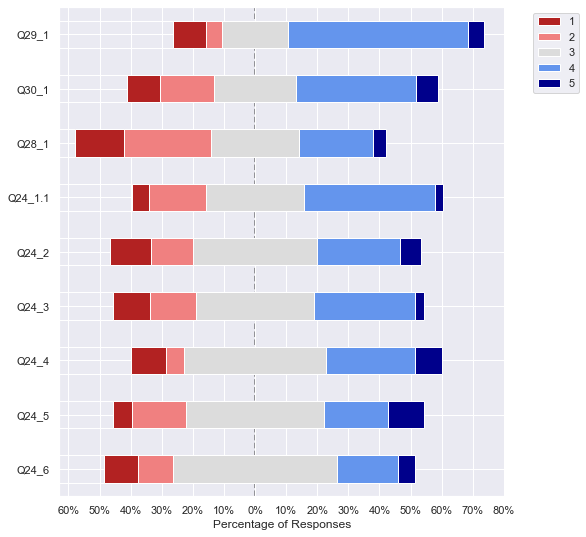

In [446]:
def makeLikert(Section,Plttitle,maxValue=5):
    
    Section=Section.replace(0,np.nan)

    N=len(Section.columns)
    import plot_likert
    for column in Section.columns:
        Section[column]=Section[column].dropna().astype(int).astype(str)
       
    plot_likert.plot_likert(Section, plot_likert.scales.raw5, plot_percentage=True,figsize=(8,1*N));

    #plt.savefig("jpgs/"+"".join(filter(str.isalnum, Plttitle))+".jpg",dpi=300,bbox_inches="tight")
        


makeLikert(Likert_Q,"Likert_education")

# Comparing Mean Values: MannU, t-Test, Anova

In [461]:
import random ### Select random Columns and show a jointplot

RandomColumns=list(random.choice(list(corrDict)))
df=Numerical_Q[RandomColumns]

print(stats.ttest_ind(Likert_Q[RandomColumns[0]],Likert_Q[RandomColumns[1]],nan_policy='omit'))

df.describe()



Ttest_indResult(statistic=0.16339416715965255, pvalue=0.8706789199445438)


,Q24_1.1,Q24_2
count,41.00000,31.000000
mean,2.95122,2.903226
std,1.24401,1.220788
min,0.00000,0.000000
25%,2.00000,2.000000
50%,3.00000,3.000000
75%,4.00000,4.000000
max,5.00000,5.000000


Index(['Q24_4', 'Q29_1'], dtype='object')
3.31 1.14
3.44 1.09


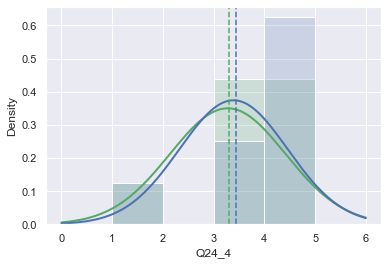

(0.0, 1.0, 0, array([3., 3., 4., 1., 1., 4., 5., 3., 3., 4., 4., 5., 3., 3., 4., 3.]))
Ttest_indResult(statistic=-0.31675613357997523, pvalue=0.7536224219438258)


In [462]:
def NormCourve(Series):
    from scipy.stats import norm
    STD=round(Series.std(),2)
    MEAN=round(Series.mean(),2)
    print(MEAN,STD)
    
    data = norm.rvs(MEAN, STD, size=1000)
    mu, std = norm.fit(data)
    p = norm.pdf(x, mu, std)
    return p


cols=nonBinary_Q.sample(n=2,axis='columns').dropna()


Series1=cols.iloc[:,0].dropna()
Series2=cols.iloc[:,1].dropna()

print(cols.columns)

xmin,xmax=min([Series2.min(),Series1.min()]),max([Series2.max(),Series1.max()])


x = np.linspace(xmin-1, xmax+1, 2000)

d1=NormCourve(Series1)
d2=NormCourve(Series2)

sns.histplot(Series1, stat='density', color='g', alpha=0.2, bins=len(Series1.unique()))
sns.histplot(Series2, stat='density', color='b', alpha=0.2, bins=len(Series2.unique()))


xmin, xmax = plt.xlim()


plt.plot(x, d1, 'g', linewidth=2)
plt.plot(x, d2, 'b', linewidth=2)


plt.axvline(x=Series1.mean(), color='g', label='Mean1', ls='--')
plt.axvline(x=Series2.mean(), color='b', label='Mean1', ls='--')


plt.show()


print(stats.chi2_contingency(Series1[~(Series1==0)], Series2[~(Series2==0)]))


print(stats.ttest_ind(Series1, Series2,nan_policy='omit'))

In [471]:
### unsicher was hier rauskommt.

cols=nonBinary_Q.sample(n=2,axis='columns')

def chisq_of_df_cols(df):
    columns=df.columns.tolist()
    print(columns)
    groupsizes = df.groupby(columns).size()
    ctsum = groupsizes.unstack()
    print(groupsizes.unstack())
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(stats.chi2_contingency(ctsum.fillna(0)))


s,p,x,df=chisq_of_df_cols(cols)
print(s,p)
df=pd.DataFrame(df)
df

['Q24_1.1', 'Q24_6']
Q24_6    0.0  1.0  2.0   3.0  4.0  5.0
Q24_1.1                               
0.0      2.0  NaN  NaN   NaN  NaN  1.0
1.0      NaN  2.0  NaN   NaN  NaN  NaN
2.0      NaN  1.0  2.0   2.0  NaN  NaN
3.0      NaN  1.0  1.0   6.0  1.0  NaN
4.0      NaN  NaN  1.0  11.0  4.0  NaN
5.0      NaN  NaN  NaN   NaN  1.0  NaN
65.65285087719298 1.666160890234532e-05


,0,1,2,3,4,5
0,0.166667,0.333333,0.333333,1.583333,0.500000,0.083333
1,0.111111,0.222222,0.222222,1.055556,0.333333,0.055556
2,0.277778,0.555556,0.555556,2.638889,0.833333,0.138889
3,0.500000,1.000000,1.000000,4.750000,1.500000,0.250000
4,0.888889,1.777778,1.777778,8.444444,2.666667,0.444444
5,0.055556,0.111111,0.111111,0.527778,0.166667,0.027778


<AxesSubplot: >

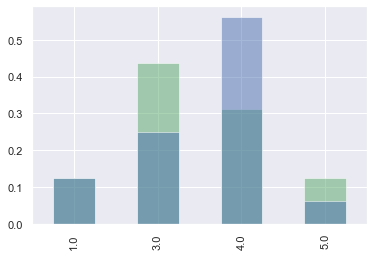

In [472]:

dfB1=(Series1.value_counts()/Series1.count()).sort_index()

dfB1.plot.bar(color='g', alpha=0.5)


dfB2=(Series2.value_counts()/Series2.count()).sort_index()
dfB2.plot.bar(color='b', alpha=0.5)


{'Q24_2': (2.903225806451613, 0, 0.6396394118755291, 1.2207876886032072, 0.21925994152214748, 0.42974948538340907), 'Q30_1': (2.9833333333333334, 0, 0.16840304680298446, 1.2952542668600668, 0.1672166068217712, 0.32774454937067155), 'Q29_1': (3.4210526315789473, 0, 0.0008478278536606867, 1.0706067580626215, 0.24561403508771926, 0.4814035087719297), 'Q10_1': (5.290322580645161, 1, 0.0008478278536606867, 2.673244575256777, 0.480128899330431, 0.9410526426876448)}


,mean,rank,MWU p-value to next rank,std,sem,95%-CI
Q24_2,2.903226,0.0,0.639639,1.220788,0.219260,0.429749
Q30_1,2.983333,0.0,0.168403,1.295254,0.167217,0.327745
Q29_1,3.421053,0.0,0.000848,1.070607,0.245614,0.481404
Q10_1,5.290323,1.0,0.000848,2.673245,0.480129,0.941053


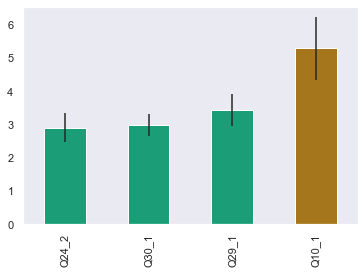

In [473]:
def MannUPairWise(df,pLimit=0.05):

    df=df.reindex(df.mean().sort_values().index, axis=1) 
    # Sort Columns by Mean Value to compare 2 Columns
    
    rank=0
    result={}
    for i in range(len(df.columns)-1):

        A=df.iloc[:,i].dropna()
        B=df.iloc[:,i+1].dropna()
        s,p=stats.mannwhitneyu(A,B)
        #print(A,s)
        result[df.columns[i]]=(A.mean(),rank, p,A.std(),A.sem(),(A.std()/len(A)**0.5)*1.96)
        if p<pLimit:
            rank+=1
        result[df.columns[i+1]]=(B.mean(),rank, p,B.std(),B.sem(),(B.std()/len(B)**0.5)*1.96) ## sem standarderror, 95%CI = 1.96*sem
        
    print(result)
    
    MannU=pd.DataFrame(result).T
    MannU.columns=['mean','rank','MWU p-value to next rank','std','sem',"95%-CI"]
    return(MannU)




df=Numerical_Q.sample(4,axis='columns')


MannU=MannUPairWise(df,pLimit=0.05)
#MannU=MannUPairWise(Likert_Q.iloc[:,:3],pLimit=0.0001)

#df OR  PrepByEducation


import matplotlib.pyplot as plt


Cmap=(MannU['rank']/(0.001+MannU['rank'].max()))*0.8

MannU['mean'].plot.bar(color=Cmap.map(plt.cm.Dark2),yerr=MannU['95%-CI'], grid=0) ### 2 times the standarderror

pd.DataFrame(MannU)

#plt.savefig("jpgs/PrepByEdu_MannU.jpg",dpi=300,bbox_inches="tight")
